# Recap last lecture
- linear averaging dynamics
- lazy linear averaging dynamics: time of convergence
- wisdowm of crowds: the effect of democracy
- linear flow dynamics

**Any questions?**

# Today's lecture
- how to compute left dominant eigenvectors of P using linear flow dynamics
- ratio bottlenecks and second dominant eigenvalue
- linear averaging dynamics (not lazy): time of convergence
- how to compute distributed average using linear averaging dynamics
- dynamics with inputs: intervention problems
- resistor networks
- duality between resistor networks and averaging dynamics

### How to compute left dominant eigenvectors (invariant distributions) by linear flow dynamics

Let $G=(V,E,W)$ be a weighted graph, and $x(t) \in \mathrm{R}^{V}$ denote the total mass in the node of the graph.

The dynamics of $x(t)$ reads

$$
x(t+1) = P'x(t),
$$

where $P$ is the normalized adjacency matrix of the graph and is called in this context the **routing matrix**.
The routing matrix has the following interpretation: if $x_j$ is the total mass in node $j$, $P_{ji}$ is the fraction of the mass that will be routed in node $i$ at the next step, i.e.,

$$
x_i(t+1) = \sum_{j} P_{ji} x_j(t)
$$

The equilibria of the dynamics satisfy $x=P'x$, i.e., $x$ is a left dominant eigenvector of $P$.

The dynamics will converge to an equilibrium if all the components corresponding to sinks of the condensation graph (i.e., attractive components) are aperiodic.

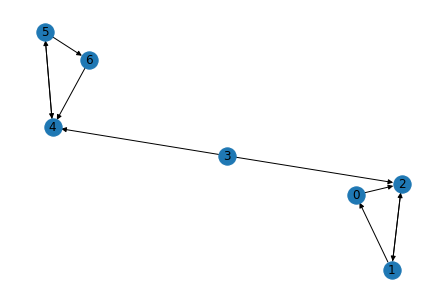

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from([(1,2),(2,1),(1,0),(0,2),(3,2),(3,4),(4,5),(5,4),(6,4),(5,6)])

# labels of nodes are couples: (column,row)
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True)

The graph above has two trapping sets (sinks in the condensation graph), both aperiodic.

Let us recall some properties on left dominant eigenvectors of $P$.

**Left dominant eigenvectors**: recall that 
- the eigenvalue 1 has multeplicity (both geometric and algebraic) equal to the number of sinks of the condensation graph;
- all the left dominant eigenevctors of $P$ has support on the nodes that belong to the trapping sets of the graph;
- dominant eigenvectors whose support belong to one trapping set only are called extremal;
- all the dominant eigenvectors can be obtained as a convex combination of extremal dominant eigenvectors.

To compute all the dominant eigenvectors, we run the dynamics with a non-zero mass in both the trapping sets of the graph.

In [2]:
# at least a non-zero element in x[0], x[1], x[2] (first trapping set)
# at least a non-zero element in x[4], x[5], x[6] (second trapping set)
x = np.array([1,0,3,2,3,1,6])

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

for iter in range(100):
    x = P.T @ x

print("x(100):", x)

x(100): [2.  2.  1.  0.  4.4 4.4 2.2]


The mass distribution in the trapping sets reaches an equilibrium (because both the trapping sets are aperiodic). 
Note indeed that eventually all the mass will flow out from non-trapping sets ($x[3] \to 0$ for large times). Once $x$ approaches zero for all the nodes not belonging to trapping sets, the dynamics in each trapping set becomes independent of the rest of the network. Thus, we can use theoretical results to guarantee that if a trapping set of the graph is aperiodic, then the dynamics on the subgraph will converge to the (unique) invariant distribution of the induced subgraph defined on the trapping set.

If the dynamics reaches an equilibrium, the resulting $x^*$ has to be left dominant eigenvector. However, if we run another dynamics with different initial condition we get another left dominant eigenvector...

In [3]:
# normalization
print("Left dominant eigenvector:", x/np.sum(x))

x = np.array([0,0,1,0,3,1,6])

for iter in range(100):
    x = P.T @ x

print("Left dominant eigenvector:", x/np.sum(x))

Left dominant eigenvector: [0.125  0.125  0.0625 0.     0.275  0.275  0.1375]
Left dominant eigenvector: [0.03636364 0.03636364 0.01818182 0.         0.36363636 0.36363636
 0.18181818]


We cannot try an infinite number of initial conditions...

To obtain all the dominant eigenvectors, we first obtain the two extremal ones $\pi^{(1)}$ and $\pi^{(2)}$, and then combine then by convex combination, i.e.,

$$
\pi = \alpha \pi^{(1)} + (1-\alpha) \pi^{(2)}.
$$

To compute the two extremal eigenvalue it suffices to isolate the nodes that refer to the trapping set.

In [4]:
x1 = np.zeros(G.number_of_nodes())
x1[0:3] = x[0:3]

print("First extremal dominant eigenvector:", x1/sum(x1))

x2 = np.zeros(G.number_of_nodes())
x2[4:7] = x[4:7]

print("Second extremal dominant eigenvector:", x2/sum(x2))

First extremal dominant eigenvector: [0.4 0.4 0.2 0.  0.  0.  0. ]
Second extremal dominant eigenvector: [0.  0.  0.  0.  0.4 0.4 0.2]


An alternative is to run a dynamics with non-zero initial condition on a trapping set only, e.g., for the first trapping set:

In [5]:
x = np.array([7,2,1,0,0,0,0])

for iter in range(100):
    x = P.T @ x

print("First extremal dominant eigenvector:", x/np.sum(x))

x = np.array([0,0,0,0,3,4,3])

for iter in range(100):
    x = P.T @ x

print("Second extremal dominant eigenvector:", x/np.sum(x))

First extremal dominant eigenvector: [0.4 0.4 0.2 0.  0.  0.  0. ]
Second extremal dominant eigenvector: [0.  0.  0.  0.  0.4 0.4 0.2]


### Ratio bottleneck (for simple graphs)

**Definition**: the ratio bottleneck (for simple graphs) is

\begin{equation}
\begin{aligned}
	\Phi = \ & \underset{\substack{\mathcal{U} \subset \mathcal{V}: \\ 0<w_{\mathcal{U}} \le \frac{1}{2} \mathbf{1}' w}}{\min}
	& & \frac{|\partial_{\mathcal{U}}|}{w_{\mathcal{U}}}
\end{aligned}
\end{equation}

The ratio bottleneck is a measure of connectedness of the graph, and is related to $\lambda_2$. The higher $\lambda_2$ is, the less connected the graph is, the smaller is $\Phi$, and the slower the convergence is. In particular,

$$
\frac{1}{2} \Phi^2 \le 1-\lambda_2 \le 2 \Phi
$$

**Example: complete graph**

The properties of a subset $\mathcal{U}$ are completeley determined by its cardinality. Let us consider a complete graph with $n$ nodes, and let $\mathcal{U}_m$ denote an arbitrary subset of $m$ nodes of the complete graph. Its boundary has cardinality $|\partial_{\mathcal{U}_m}| = m \cdot (n-m)$, thus

\begin{equation}
\begin{aligned}
	\Phi = \ & \underset{m \le n/2}{\min}
	& & \frac{m(n-m)}{m(n-1)} \rightarrow \frac{1}{2}
\end{aligned}
\end{equation}

as $n \to +\infty$.

**Example: barbell graph**

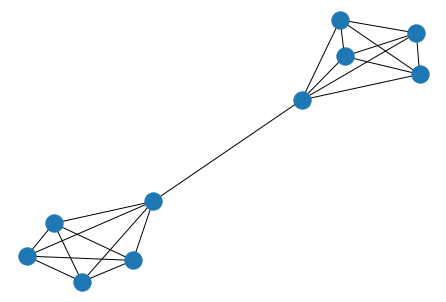

In [6]:
G = nx.barbell_graph(5,0)

pos = nx.spring_layout(G) 
nx.draw(G,pos)

The bottleneck is clearly to select one of the two complete components of the graph.
For that $\mathcal{U}$,

$$
|\partial_{\mathcal{U}} = 1|, \quad w_{\mathcal{U}} = n(n-1)+1,
$$

where $2n$ is the order of the graph. Thus, for large $n$

$$
\Phi = \frac{1}{n^2-n+1} \rightarrow 0,
$$

which implies that $\lambda_2 \to 1$ and the convergence is slow.

**Question**: is the convergence always slow? 
    
No, it depends on the initial condition.

While $\lambda_2$ describes a worst-case scenario for the speed of convergence, it might be that for some initial condition the convergence is fast!

For instance, let us compare a random initial condition with an initial condition which has a high disagreement along the two components of the bottleneck of the graph.

In [7]:
G = nx.barbell_graph(150,0)

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# Construct lazy P
P = P/2 + np.diag(np.ones(G.number_of_nodes()))/2

# let us start with random initial condition
x = np.random.rand(G.number_of_nodes())>1/2

variance = np.var(x)
t=0

while (variance>0.001):
    x = P @ x
    t=t+1
    variance = np.var(x)

print('Number of iteration for convergence:', t)

# let us start with a specific initial condition which maximizes the disagreement along the bottleneck of the graph, i.e.,
# a complete subgraph has all zeros, and the second one has all ones.
x = np.zeros(G.number_of_nodes())
x[0:int(G.number_of_nodes()/2)] = np.ones(int(G.number_of_nodes()/2))

variance = np.var(x)
t=0

while (variance>0.0002):
    x = P @ x
    t=t+1
    variance = np.var(x)

print('Number of iteration for convergence:', t)

Number of iteration for convergence: 5
Number of iteration for convergence: 80746


Even though $\lambda_2 \to 1$, with a random initial condition the two complete graphs mix the opinions quickly and reach an agreement within the component in a few iterations. On average, both the components tend to opinion $1/2$, which mean that there is no large disagreements between the two components.

On the other hand, if a component has opinion $0$ and the other one has opinion $1$, since the two complete components are not well connected, it takes a lot to reach consensus.

### Back to (not lazy) averaging dynamics

In lazy dynamics the speed of convergence is described by $\lambda_2$. In standard averaging dynamics, also $\lambda_n$ plays a role. We recall indeed that the speed of convergence is described by

$$
\lambda := \max\{\lambda_2,|\lambda_n|\},
$$

where $\lambda_n$ is the smallest eigenvalue of $P$.

While $\lambda_2$ is related to the level of connectedness of the graph, we shall see in a qualititive manner the role of $\lambda_n$ by doing examples.

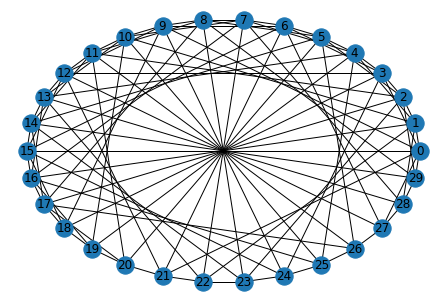

In [8]:
# let us construct a regular graph with 6m nodes, and degree of each node equal to m

m = 5
G = nx.cycle_graph(6*m)

n_nodes = 6*m

for n in range(6*m):
    for i in range(m):
        G.add_edge(n,(6*(i+1)+n-3) % 18)

pos = nx.circular_layout(G)

nx.draw(G,pos,with_labels=True)

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

In [9]:
w,v = np.linalg.eig(P)
w = w.real

print(w)

[-1.          1.         -0.52488952 -0.52280183 -0.48487248  0.52488952
  0.52280183  0.48487248 -0.41010154  0.41010154 -0.35293579 -0.31356298
 -0.27061836 -0.24909197 -0.22801768 -0.19026041  0.35293579  0.31356298
  0.27061836  0.24909197  0.22801768  0.19026041 -0.12892586  0.12892586
 -0.07951513 -0.03171327 -0.03535887  0.07951513  0.03171327  0.03535887]


Since $-1$ is in the spectrum of $P$, the graph is periodic and the dynamics cannot converge. In fact, one can observe that the graph is bipartite. Thus, the convergence is not guaranteed.

Let us now add a single edge to break the periodicity while mantaining the total number of edges.

[ 1.         -0.9836554  -0.53080863 -0.51343314 -0.48639675  0.52427039
  0.50347848  0.4966976  -0.41731173  0.41043809  0.35327071  0.34164528
 -0.3528659  -0.31426402  0.28893342  0.26433602  0.22877419  0.18484969
 -0.27192896 -0.26523542 -0.21543669 -0.18245434 -0.15294277  0.11609839
  0.08043962 -0.07670712 -0.04026661 -0.02695449  0.00172572  0.03570437]


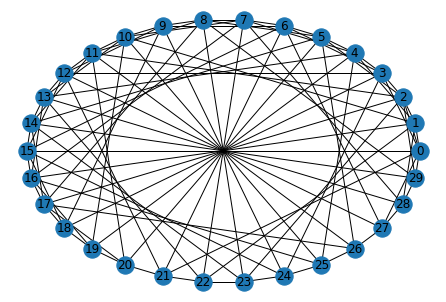

In [10]:
G.add_edge(0,2)
G.remove_edge(0,9)

nx.draw(G,pos,with_labels=True)

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

w,v = np.linalg.eig(P)
w = w.real

print(w)

The graph is not periodic now. However, $|\lambda_n| \sim 1$, which implies that the convergence of the dynamics is slow. On the other hand, $\lambda_2$ is "small" ($\sim 1/2$), thus the lazy dynamics converges quickly.

In some sense, $|\lambda_n| \sim 1$ reflects the fact that the graph is almost periodic. Let us see this with an example, by comparing the speed in convergence of the lazy dynamics and the standard dynamics.

In [11]:
# construct a larger graph
m = 50
G = nx.cycle_graph(6*m)

G.add_edge(0,2)

n_nodes = 6*m

for n in range(6*m):
    for i in range(m):
        G.add_edge(n,(6*(i+1)+n-3) % n_nodes)
        

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# let us start with random initial condition and standard dynamics
x0 = np.random.rand(G.number_of_nodes())>1/2
x = x0

variance = np.var(x)
t=0

while (variance>0.00001):
    x = P @ x
    t=t+1
    variance = np.var(x)
    if t>100000:
        t='inf'
        break
        
print('Number of iterations for convergence of standard dynamics:', t)

# same initial condition, lazy dynamics
x = x0

# Construct lazy P
P = P/2 + np.diag(np.ones(G.number_of_nodes()))/2

variance = np.var(x)
t=0

while (variance>0.00001):
    x = P @ x
    t=t+1
    variance = np.var(x)
    if t>100000:
        t='inf'
        break
        
print('Number of iterations for convergence of lazy dynamics:', t)

Number of iterations for convergence of standard dynamics: 10283
Number of iterations for convergence of lazy dynamics: 91


While the speed of convergence in the lazy dynamics depends only on the connectivity of the graph ($\lambda_2$), the speed of convergence in the standard dynamics depends both on the connectivity ($\lambda_2$) and the periodicity of the graph ($|\lambda_n|$). The example above shows that the standard averaging dynamics may converge slowly when the graph is a perturbation of a periodic graph, even if the dynamics is well-connected.

### Application: distributed computation of average

Let the node set describe a set of sensors that are deployed in some region in order to collect measurements of some quantity of interest (for example, the temperature). 

Assume that these sensors have limited communication and computation capabilities that allow each of them to exchange information only with those other sensors that are close enough in space. 

Let the graph $G = (V, E)$ describe the pattern of vicinity among the sensors $i$ and $j$ so that there is an undirected link between node $i$ and node $j$ if they can communicate to each other (possibly using link weights decreasing with distance). Then, one can design a distributed algorithm for computing the average of the sensor's measurements based on the averaging dynamics.

Let $x_i(0)$ be the measurement of each node. 

We are interested in designing an iterative distributed algorithm that allows the nodes to compute

$$
x = \frac{1}{n}\sum_i x_i(0)
$$

**First attempt**: we run a consensus algorithm. Since the graph is undirected, $\pi_i = \frac{w_i}{\sum_j w_j}$. Thus, the algorithm converges to a consensus $\alpha \mathbf{1}$ such that

$$
\alpha = \sum_{i} \frac{w_i}{w} x_i(0),
$$

which differs from our goal.

If each edge knows its degree $w_i$, each node can rescale its initial state, i.e., $y_i(0) = \frac{x_i(0)}{w_i}$. The consensus algorithm for the variable $y_i$ thus converges to

$$
\alpha_y = \sum_{i} \frac{w_i}{w} y_i(0) = \frac{1}{w} \sum_{i} x_i(0).
$$

If we assume that each node knows the average degree of the network $\overline{w}$, thus

$$
x = \alpha_y \frac{w}{n} = \alpha_y \overline{w}.
$$


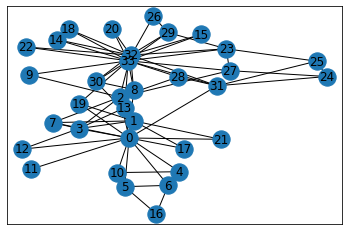

In [12]:
G = nx.karate_club_graph()

# Fix node positions on all pictures according to spring layout
pos = nx.spring_layout(G) 
nx.draw_networkx(G, pos)

n_nodes = len(G)

x = np.random.rand(n_nodes)

In [13]:
# Let us run the consensus algorithm for y

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

y = x/degrees

for t in range(1000):
    y = P @ y

print("average initial condition:", np.mean(x))
# choose arbitrarly the first node, but all the nodes reach consensus on y
print("average computed distributively", y[0] * np.sum(degrees) / n_nodes)

average initial condition: 0.5276798221425357
average computed distributively 0.5276798221425343


The algorithm works! Unfortunately, requiring that each node knows the average degree of the network is not realistic and is not distributed, because it requires that each node has some global information on the network.

However, there exists another way to solve the problem in a distributed manner.

We run a second averaging dynamics, with initial condition $z_i(0) = \frac{1}{w_i}$.

This converges to

$$
\lim_{t \to + \infty} z_i(t) = \sum_i z_i(0) \frac{w_i}{w} = \sum_{i} \frac{1}{w} = n/w = 1/\overline{w}
$$

By combining the two, each node can estimate the average estimate by 

$$
\frac{\lim_{t \to + \infty} y_i(t)}{\lim_{t \to + \infty} z_i(t)} = \alpha_y / \overline{w} = x
$$

In [14]:
# Let us implement this

z = 1/degrees

for t in range(1000):
    z = P @ z

print("average state:", np.mean(x))
# choose arbitrarly the first node, but all the nodes reach consensus both on y and z
print("average computed distributively", y[0] / z[0])

average state: 0.5276798221425357
average computed distributively 0.5276798221425358


# Linear averaging dynamics with stubborn agents
In the second part of the lab we study how to simulate the linear averaging dynamics on graphs in presence of stubborn agents.

We focus on the optimal placement problem, which consists of optimally chosing the position of a stubborn node on the graph in order to maximize its influence on the asymptotic outcome of the dynamics.

Let us first summarize the theory in presence of stubborn agents.

We are given a network, where the agents $V$ are divided in regular agents $R$ and stubborn agents $S$. The regular agents update their opinion $x(t)$ according to the standard DeGroot model, while the stubborn agents do not update their opinion $u(t) \equiv u$.

Let $Q=P|_{R \times R}$ and $E=P|_{R \times S}$.

Thus, the dynamics for the regular agents read:

$$
x(t+1) = Qx(t) + Eu.
$$

Under some assumptions (see the lecture notes from the theoretical perspective) the dynamics converges to 

$$
x^* = (\mathbf{I}-Q)^{-1}Eu.
$$

Note that:
- the asymptotic state is not a consensus;
- the asymptotic state does not depend on the initial opinions.

### Implementation

We start with implementing the averaging dynamics with stubborn nodes. 

To illustrate this procedure, we will analyse the following example that involves a $3 \times 4$ grid graph $\mathcal G$.

First, we construct such graph.

Number of nodes: 12
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]


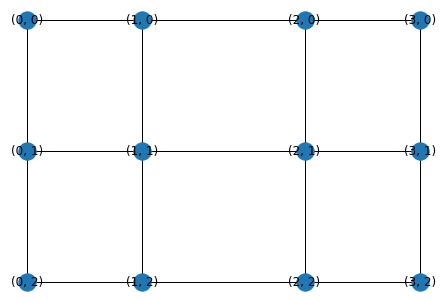

In [15]:
G = nx.generators.lattice.grid_graph(dim=[3,4])
n_nodes = len(G)
print("Number of nodes:", n_nodes)

# labels of nodes are couples: (column,row)
nx.draw_spectral(G, with_labels=True)

print(G.nodes())

In [16]:
# Construct a dictionary that maps the label of nodes  
# (from (0,0) to (2,1)) to their index (from 0 to n_nodes-1)
indices = dict()
for i in range(n_nodes):
    indices[list(G.nodes)[i]] = i
print(indices)

{(0, 0): 0, (0, 1): 1, (0, 2): 2, (1, 0): 3, (1, 1): 4, (1, 2): 5, (2, 0): 6, (2, 1): 7, (2, 2): 8, (3, 0): 9, (3, 1): 10, (3, 2): 11}


In [17]:
# Number of iterations
n_iter = 50;
    
# Stubborn and regular nodes
stubborn = [(0,0), (3,2)];
stubborn_id = [indices.get(key) for key in stubborn]
regular = [node for node in G.nodes if node not in stubborn]
regular_id = [id for id in range(n_nodes) if id not in stubborn_id]
print("Stubborn nodes:", stubborn, "\n")
print("Regular nodes:", regular, "\n")

# Input to stubborn nodes
u = [0,1]

# P matrix
A = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

# Submatrices
# Using ix_ one can construct index arrays that will 
# index a cross product. 
# a[np.ix_([1,3],[2,5])] returns the array [[a[1,2] a[1,5]], [a[3,2] a[3,5]]].
Q = P[np.ix_(regular_id, regular_id)]
E = P[np.ix_(regular_id, stubborn_id)]

# Sample a random initial condition for regular nodes
ic = np.random.uniform(0,1,len(regular))

# Set the initial condition for the dynamics
x = np.zeros((n_nodes,n_iter))
x[stubborn_id,0] = u;
x[regular_id,0] = ic;
print("Initial condition:", x[:,0], "\n")

# Evolve the opinion vector
for t in range(1,n_iter):
    x[regular_id, t] = Q @ x[regular_id, t-1] + E @ x[stubborn_id, t-1]
    x[stubborn_id, t] = x[stubborn_id, t-1];

x_final = x[:,n_iter-1]
for key in indices.keys():
    print(key, x_final[indices[key]])


Stubborn nodes: [(0, 0), (3, 2)] 

Regular nodes: [(0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1)] 

Initial condition: [0.         0.94622178 0.31048412 0.40435781 0.51750329 0.82472195
 0.46911574 0.165013   0.1371101  0.16958296 0.29597289 1.        ] 

(0, 0) 0.0
(0, 1) 0.2640700373534249
(0, 2) 0.3802144032155633
(1, 0) 0.3053861711281012
(1, 1) 0.41327187370860063
(1, 2) 0.49532542995718015
(2, 0) 0.504182873594969
(2, 1) 0.586255032916561
(2, 2) 0.6942521339090373
(3, 0) 0.619308853165292
(3, 1) 0.7355738655321891
(3, 2) 1.0


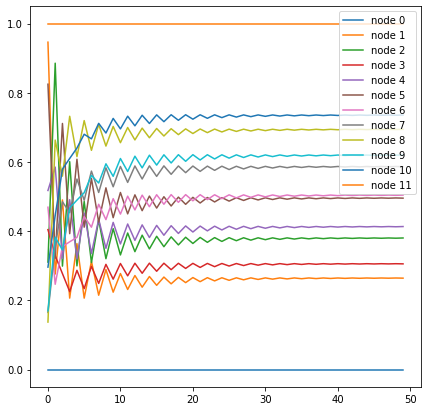

In [18]:
import matplotlib.pyplot as plt
    
fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(n_nodes):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()

In [19]:
average = np.average(x_final)
print("Average asymptotic opinion:", average)

Average asymptotic opinion: 0.49982005620674325


As expected, the dynamics does not converge to consensus. Moreover, in contrast with averaging without input stubborn nodes, we can verify that the asymptotic equilibrium does not depend on the initial condition.

Initial condition: [0.         0.10286311 0.35904647 0.07421043 0.87891225 0.70217795
 0.22618923 0.71485682 0.32144575 0.15303287 0.01672066 1.        ] 

(0, 0) 0.0
(0, 1) 0.2641780563623317
(0, 2) 0.37999492465443
(1, 0) 0.30549588680170414
(1, 1) 0.4130540802432694
(1, 2) 0.49547458162974234
(2, 0) 0.5039565232256046
(2, 1) 0.5863985398468847
(2, 2) 0.6940856240787401
(3, 0) 0.6194534662295788
(3, 1) 0.7354099384399915
(3, 2) 1.0


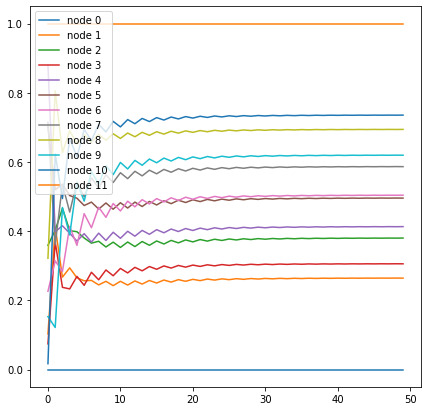

In [20]:
# Sample another random initial condition for regular nodes
ic = np.random.uniform(0,1,len(regular))

x = np.zeros((n_nodes,n_iter))
x[stubborn_id,0] = u;
x[regular_id,0] = ic;
print("Initial condition:", x[:,0], "\n")

# Evolve the opinion vector
for t in range(1,n_iter):
    x[regular_id, t] = Q @ x[regular_id, t-1] + E @ x[stubborn_id, t-1]
    x[stubborn_id, t] = x[stubborn_id, t-1];

x_final = x[:,n_iter-1]
for key in indices.keys():
    print(key, x_final[indices[key]])
    
fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(n_nodes):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()

## Optimal placement of stubborn nodes
Suppose that node $(0,0)$ is stubborn with opinion $u_{(0,0)}=0$. We want to find the optimal position $(i,j)$ of a stubborn node with opinion $1$ in order to maximize the asymptotic average opinion.

A very simple approach is to consider all possible positions $(i,j)$ and pick the best one.

In [21]:
# Number of iterations
n_iter = 50;

# We will store final opinion vectors and 
# average of final opinions in dictionaries
# where the key is the position (i,j) of the 
# 1-stubborn agent
final_opinions = dict()
average_opinion = dict() 


for (i,j) in G.nodes:
    # Position (0,0) is occupied by the 0-stubborn node
    if (i,j)==(0,0):
        continue
        
    # Stubborn and regular nodes
    stubborn = [(0,0), (i,j)];
    stubborn_id = [indices.get(key) for key in stubborn]
    regular = [node for node in G.nodes if node not in stubborn]
    regular_id = [id for id in range(n_nodes) if id not in stubborn_id]
    print("Stubborn nodes:", stubborn)

    # Input to stubborn nodes
    u = [0,1]


    # P matrix
    A = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
    A = A.toarray() # convert A to a numpy array
    degrees = np.sum(A,axis=1)
    D = np.diag(degrees)
    P = np.linalg.inv(D) @ A

    # Submatrices
    Q = P[np.ix_(regular_id, regular_id)]
    E = P[np.ix_(regular_id, stubborn_id)]

    # Sample a random initial condition for regular nodes
    ic = np.random.uniform(0,1,len(regular))

    # Set the initial condition for the dynamics
    x = np.zeros((n_nodes,n_iter))
    x[stubborn_id,0] = u;
    x[regular_id,0] = ic;

    for t in range(1,n_iter):
        x[regular_id, t] = Q @ x[regular_id, t-1] + E @ x[stubborn_id, t-1]
        x[stubborn_id, t] = x[stubborn_id, t-1];

    final_opinions[(i,j)] = x[:,n_iter-1]
    average_opinion[(i,j)] = np.average(final_opinions[(i,j)])
    print("Average opinion:", average_opinion[(i,j)], "\n")

Stubborn nodes: [(0, 0), (0, 1)]
Average opinion: 0.6234931066127616 

Stubborn nodes: [(0, 0), (0, 2)]
Average opinion: 0.4966738425719033 

Stubborn nodes: [(0, 0), (1, 0)]
Average opinion: 0.6701627906372626 

Stubborn nodes: [(0, 0), (1, 1)]
Average opinion: 0.7139222556125979 

Stubborn nodes: [(0, 0), (1, 2)]
Average opinion: 0.6037005903953404 

Stubborn nodes: [(0, 0), (2, 0)]
Average opinion: 0.6019847030586488 

Stubborn nodes: [(0, 0), (2, 1)]
Average opinion: 0.6588834979892545 

Stubborn nodes: [(0, 0), (2, 2)]
Average opinion: 0.5884519264910467 

Stubborn nodes: [(0, 0), (3, 0)]
Average opinion: 0.49955101862306234 

Stubborn nodes: [(0, 0), (3, 1)]
Average opinion: 0.5579819846508512 

Stubborn nodes: [(0, 0), (3, 2)]
Average opinion: 0.49984491243557283 



To visualize the dependence of the average asymptotic opinion on the position of the $1$-stubborn node we can plot the grid graph by setting each node's size and color according to the magnitude of the average asymptotic opinion when the $1$-stubborn is placed in such node.

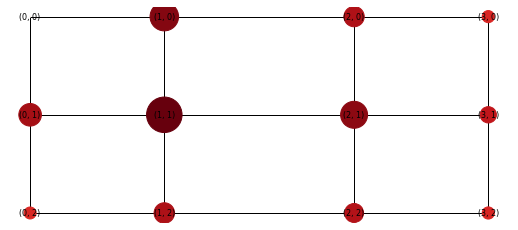

In [22]:
# add a dummy (0,0) entry to the dictionary
# to make its size = n_nodes
average_opinion[(0,0)] = 0

plt.figure(1, figsize=(7,3))
nx.draw(G, 
        pos = nx.spectral_layout(G),
        with_labels=True, 
        node_size = [np.exp(10*average_opinion[node]) for node in G.nodes],
        node_color= [average_opinion[node] for node in G.nodes],
        font_size=8,
        # node's colors are on the red scale
        cmap=plt.cm.Reds)

The optimal placements of the 1-stubborn player are the maximizers of the final average opinion:

In [23]:
# convert the average opinion values from dict_values to numpy array
avg = np.fromiter(average_opinion.values(),dtype=float)

optimal_place = [place for place in average_opinion.keys() if average_opinion[place]==np.max(avg)]
print("Optimal placements:", optimal_place)

print(optimal_place)

# print the final opinions under optimal placement
opt_final = final_opinions.get(*optimal_place)
print(opt_final)

Optimal placements: [(1, 1)]
[(1, 1)]
[0.         0.57029951 0.71096015 0.5782163  1.         0.85163215
 0.73480649 0.84941524 0.84416872 0.77683153 0.81923094 0.83150603]


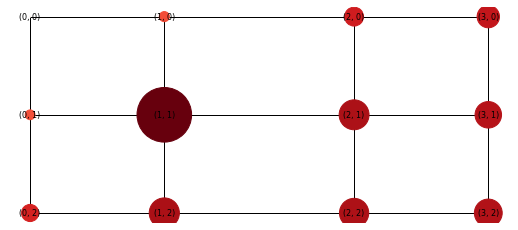

In [24]:
# plot the asymptotic opinions of the nodes when the stubborn is placed in (1,1)

plt.figure(1, figsize=(7,3))
nx.draw(G, 
        pos = nx.spectral_layout(G),
        with_labels=True, 
        node_size = [np.exp(8*opt_final[indices.get(node)]) for node in G.nodes],
        node_color= [opt_final[indices.get(node)] for node in G.nodes],
        font_size=8,
        # node's colors are on the red scale
        cmap=plt.cm.Reds)

### Back to an old example

Average final opinions: 0.9944568349086351


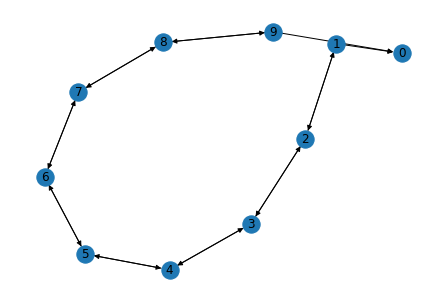

In [25]:
G = nx.cycle_graph(10)
G = nx.Graph.to_directed(G)
G.remove_edges_from([(0,1),(0,9)])
G.add_edge(0,0)

nx.draw(G, with_labels=True)

n_nodes = G.number_of_nodes()

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

n_iter = 100
x = np.zeros((10,n_iter))

# set initial condition (1,0,0,0,0,0,0,0,0,0)
x[0,0] = 1

# evolve the states
for t in range(1,n_iter):
    x[:,t] = P @ x[:,t-1]

print("Average final opinions:", np.mean(x[:,n_iter-1]))

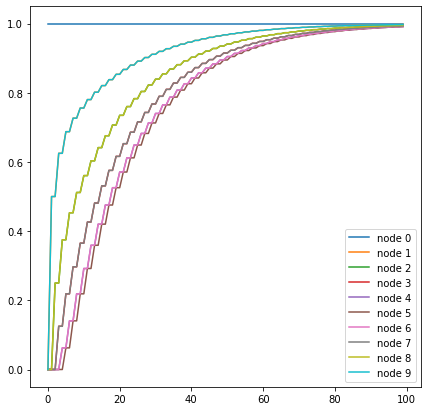

In [26]:
fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(G.number_of_nodes()):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()

We can prove that this is equivalent to having node 0 stubborn with opinion 1.

Indeed, note that because of the topology of the graph, the opinion of node 0 is not influenced by anyone. The same dynamics can be obtained by assuming that node 0 is stubborn.

In [27]:
# Stubborn and regular nodes
stubborn = [0];
regular = [node for node in G.nodes if node not in stubborn]

print("Stubborn nodes:", stubborn, "\n")
print("Regular nodes:", regular, "\n")

# Input to stubborn nodes
u = [1]

# Submatrices
Q = P[np.ix_(regular, regular)]
E = P[np.ix_(regular, stubborn)]

# Set the initial condition for the dynamics
x = np.zeros((n_nodes,n_iter))
x[stubborn,0] = u;
print("Initial condition:", x[:,0], "\n")

# Evolve the opinion vector
for t in range(1,n_iter):
    x[regular, t] = Q @ x[regular, t-1] + E @ x[stubborn, t-1]
    x[stubborn, t] = x[stubborn, t-1];

x_final = x[:,n_iter-1]
print(x_final)

Stubborn nodes: [0] 

Regular nodes: [1, 2, 3, 4, 5, 6, 7, 8, 9] 

Initial condition: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

[1.         0.99735337 0.99470675 0.99307104 0.99143534 0.99143534
 0.99143534 0.99307104 0.99470675 0.99735337]


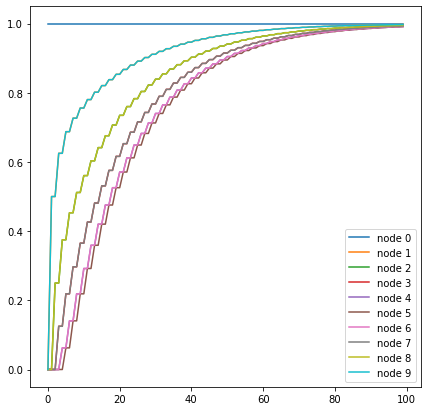

In [28]:
fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(G.number_of_nodes()):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()

Same trajectory as before!

### A more general model: overview on Friedkin-Johnsen model
The French-DeGroot dynamics can be generalized by taking into account that each agents is not completely regular or completely stubborn. The opinion of each agents is in part due to "innate" opinions, and in part due to influence of society.

The following opinion dynamics model is known as Friedkin-Johnsen model.
Here:
- $x_i(t)$ is the opinion of the agent $i$;
- $y_i$ is the innate opinion of agent $i$.
- $\alpha_i$ is its level of stubborness, i.e., the level of confidence in his/her opinion $y_i$.

The dynamics reads:

$$
x_i(t+1) = \alpha_i y_i + (1-\alpha_i) \sum_{j} P_{ij} x_j(t).
$$

If $\alpha = \mathbf{0}$, we get the French-DeGroot model without input.

If $\alpha \in \{0,1\}^{V}$, we get the French-DeGroot model with stubborn nodes.

As the French-DeGroot model with input, also the Friedkin-Johnsen dynamics converges to a non-consensus state, which depends on $\alpha, y$, but not on the initial opinions $x(0)$.

# Resistor networs

We are given an undirected weighted graph, where the weight $c_{ij}$ denotes the conductance between nodes $i$ and $j$. 
Let $x$ indicate the node potential distribution, and $\phi$ denote the current flowing in the network. Ohm's law establish the following relation between current, potential and conductances: 

$$
\phi_{ab} = c_{ab}(x_a-x_b).
$$ 

We here recall the main instruments to solve electrical network problems: **Series law, Parallel law, Gluing**

**Observation**: asymptotical opinions in French-DeGroot model with stubborn is equivalent to potential in resistor network.

Indeed, they solve the same equations, i.e., for every regular node (non-stubborn in opinion dynamics, without boundary conditions in electrical problems), 

$$x_i = \sum_j P_{ij} x_j$$ 

We can thus use this equivalence to solve a problem with the most convenient tool.

**Example: two equivalent problems**

**Problem 1**
We are given a network $G=(V,E,W)$, where $W$ is the conductance matrix of the network (we consider in this case unweighted graphs. 
Let $x_0=1, x_4=0$ be the boundary conditions on the potential. Find the potential of the other nodes.

**Problem 2**
We are given a social network $G=(V,E,W)$. Let $\{0,4\}$ the set of stubborn agents, with opinions $u_0 = 0, u_1 = 4$. Find the asymptotic opinions of French-DeGroot dynamics.

The solution of the problem is the same. Thus, we can solve only one of the two by using tools from opinion dynamics or electrical network based on what is more convenient for the problem.

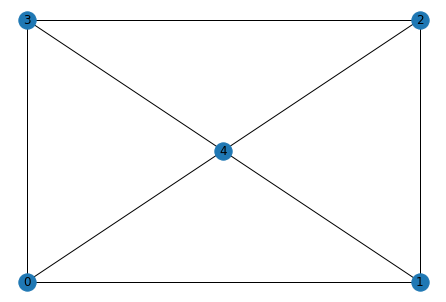

In [29]:
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3),(3,0),(0,4),(1,4),(2,4),(3,4)])

pos = {0: (0,0), 1: (2,0), 2: (2,2), 3: (0,2), 4: (1,1)}

nx.draw(G,pos, with_labels=True)

**3 methods for solving the problem**

**Method 1**
Solve the system of equations $x_i=\sum_j P_{ij} x_j$ for every regular node $i$. The system has unique solution because the graph is strongly connected.

**Method 2**
Since the graph is aperiodic, run the French-DeGroot dynamics until convergence.

**Method 3**
Use Series, parallel, and gluing laws.

We skip **Method 1**, let us start with **Method 2**.

In [30]:
# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

n_nodes = G.number_of_nodes()

stubborn = [0,4];
regular = [node for node in G.nodes if node not in stubborn]

print("Stubborn nodes:", stubborn, "\n")
print("Regular nodes:", regular, "\n")

# Input to stubborn nodes
u = [0,1]

# Submatrices
Q = P[np.ix_(regular, regular)]
E = P[np.ix_(regular, stubborn)]

# Set the initial condition for the dynamics
x = np.zeros((n_nodes,n_iter))
x[stubborn,0] = u;
print("Initial condition:", x[:,0], "\n")

# Evolve the opinion vector
for t in range(1,n_iter):
    x[regular, t] = Q @ x[regular, t-1] + E @ x[stubborn, t-1]
    x[stubborn, t] = x[stubborn, t-1];

x_final = x[:,n_iter-1]
print(x_final)

Stubborn nodes: [0, 4] 

Regular nodes: [1, 2, 3] 

Initial condition: [0. 0. 0. 0. 1.] 

[0.         0.57142857 0.71428571 0.57142857 1.        ]


**Method 3**

Note that by symmetry x_1 = x_3 ---> **Gluing**

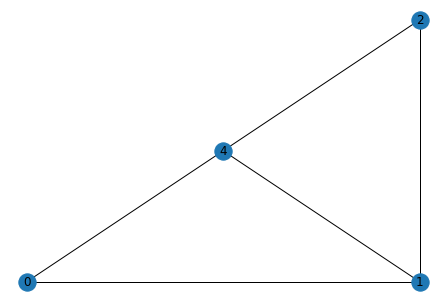

In [31]:
G1 = nx.Graph()
G1.add_edges_from([(0,1),(1,2),(0,4),(1,4),(2,4)])

pos1 = {0: (0,0), 1: (2,0), 2: (2,2), 4: (1,1)}

nx.draw(G1,pos, with_labels=True)

We have conductancies:

$$
\begin{cases}
c_{04} = c_{24} = 1, \\
c_{01} = c_{12} = c_{14} = 2.
\end{cases}
$$

We operate a series composition of edges $(2,4)$ and $(1,2)$, plus a parallel composition of the resulting link with $(1,4)$. The resulting network is:

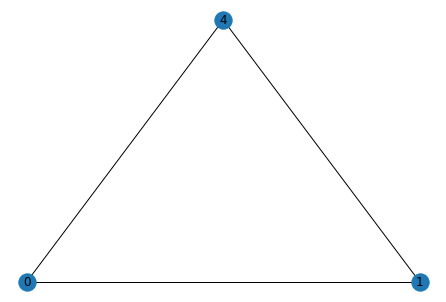

In [32]:
G2 = nx.Graph()
G2.add_edges_from([(0,1),(0,4),(1,4)])

pos1 = {0: (0,0), 1: (2,0), 4: (1,1)}

nx.draw(G2,pos, with_labels=True)

We have conductancies:

$$
\begin{cases}
c_{04} = 1, \\
c_{14} = (1/2 + 1)^{-1} + 2 = 8/3, \\
c_{01} = 2.
\end{cases}
$$

The resulting conductance of the series of links $(0,1)$ and $(1,4)$ is $(1/2+3/8)^{-1} = 8/7$.

Using the fact that $x_0 = 0, $x_4 = 1$, by Ohm's law, $\phi_{41}=\phi_{10}=8/7$.

Using again Ohm's law:

$$
2(x_1-x_0) = \phi_{10} \implies x_1 = 8/14 = 4/7 
$$

Moreover, $x_1 = x_3 = 4/7$.

Finally, by Kirchhoff's law on $G1$,

$$
(x_4 - x_2)C_{24} = (x_2-x_1)C_{12} \implies x_2 = \frac{x_4 C_{24} + x_1C_{12}}{C_{24}+C_{12}} = \frac{1+\frac{4}{7}\cdot2}{1+2} = \frac{5}{7},
$$

which is equivalent to what obtained by French-DeGroot dynamics.